In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import *
from invariance_functions import *
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

[  45.89600459 -103.53587166  -74.81390268]
[ 25.9433386  -19.6836146   -0.89915511]


(-150.0, 150.0)

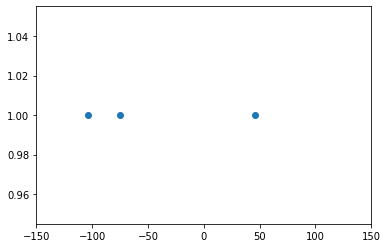

In [149]:
time_step = 0.01
training_time = 0.12
testing_time = 1

max_x = 150
max_v = 30
n_train = 3
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))
#train_starting_position = [-94.44962797, 109.27339531, -17.09278996]
#train_starting_velocity = [  1.13419609, -17.33191032,  -3.56046298]

print(train_starting_position)
print(train_starting_velocity)
data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch
import matplotlib.pyplot as plt
plt.scatter(train_starting_position, np.ones(3))
plt.xlim(-150, 150)

moi:299.12
known: 331.66
learnt: 325.76
[[1.42865612e-05]
 [2.18927810e-01]]
[[-0.00407204]
 [ 0.20172678]
 [ 0.00111481]
 [-0.02568052]]


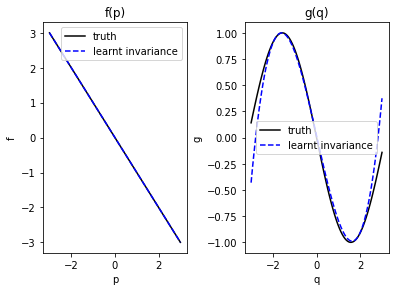

In [47]:

mean = ZeroMean(2)
moi, *dump = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 5e-4
invar_density = 50
invar_range = 3
poly_f_d = 2
poly_g_d = 4
known_kernel = get_invariance_kernel(PendulumInvariance, invar_range, invar_density, jitter) #switch
known, *dump = get_GPR_model(known_kernel, mean,data, 500)
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
learnt_kernel = get_parameterised_invariance_kernel(PolynomialInvariance, invar_range, invar_density, jitter, poly_f_d, poly_g_d) #switch
model, fs, gs, coeff = get_GPR_model(learnt_kernel, mean, data, 3000, stored=True)
print("learnt: "+ format(model.log_marginal_likelihood().numpy(),".2f"))
print(learnt_kernel.f_poly.numpy())
print(learnt_kernel.g_poly.numpy())

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-3,3,100)
multiplier = -learnt_kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -x, label='truth', color="black")
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, -np.sin(x), color="black", label='truth')
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



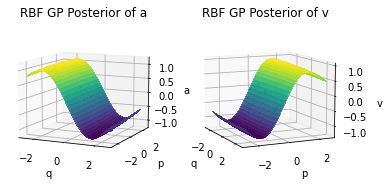

In [71]:
import matplotlib.pyplot as plt
test_range = np.radians(150)
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred, var = moi.predict_f(test_points) ######switch
X, Y = data
pred_a = pred[:int(pred.shape[0]/2),:]
var_a = var[:int(var.shape[0]/2),:]
pred_v = pred[int(pred.shape[0]/2):,:]
var_v = var[int(var.shape[0]/2):,:]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
#ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("RBF GP Posterior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.scatter(X[:,0], X[:,1],Y[:,0,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("RBF GP Posterior of v")
plt.savefig("figures/posterior_pendulum_rbf.pdf")

0
-117.37307559996086
-2.592049044837019
0.004210377566978143
0.0017739013217198765
0.001322640598777789


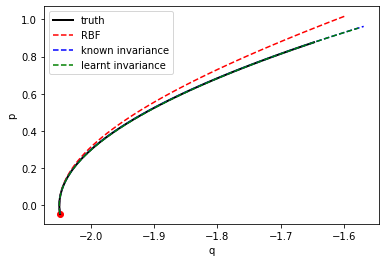

MSE & 0.0042 & 0.0018 & 0.0013 & nan & nan \\


In [74]:


eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []
eva_future_inv_l = []
eva_future_inv_lp = []

dynamics = pendulum_dynamics

# pendulum
def energy(X):
    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])

for i in range(1):
    print(i)
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))

    print(np.degrees(test_starting_position))
    print(np.degrees(test_starting_velocity))
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])

    evaluate_invariance_p =evaluate_model_future(model, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance_p[0])


    fig, ax = plt.subplots()
    plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
    plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
    plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
    plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
    plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
    plt.xlabel("q")
    plt.ylabel("p")
    plt.legend()
    plt.show()
    print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+" & "+format((np.mean(eva_future_inv_l)),".4f")+" & "+format((np.mean(eva_future_inv_lp)),".4f")+ ' \\\\')



In [50]:
print("Log Marginal Likelihood & " + format((moi.log_marginal_likelihood().numpy()),".2f")+" & "+ format((known.log_marginal_likelihood().numpy()),".2f") + " & "+ format((model.log_marginal_likelihood().numpy()),".2f") + ' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+ ' \\\\')

Log Marginal Likelihood & 299.12 & 331.66 & 325.76 \\
MSE & 0.0021 & 0.0009 & 0.0006 \\


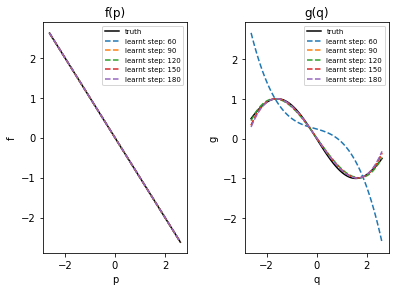

In [61]:

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-np.radians(150),np.radians(150),100)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -x, label='truth', color="black")
ax2.plot(x, -np.sin(x), color="black", label='truth')
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax2.set_title("g(q)")
ax2.set_xlabel("q")
ax2.set_ylabel("g")
for i, (f, g) in enumerate(zip(fs, gs)):
    if i%3==0 and i>3:
        multiplier = -learnt_kernel.f_poly.transform(f[1])
        f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.transform(f)))
        g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.transform(g)))
        ax1.plot(x, f(x)/multiplier, "--", label='learnt step: '+str(i*10))
        ax2.plot(x, g(x)/multiplier, "--", label='learnt step: '+ str(i*10))
ax1.legend(loc=1, prop={"size":7})
ax2.legend(loc=1, prop={"size":7})
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/pendulum_learnt_over_time.pdf")



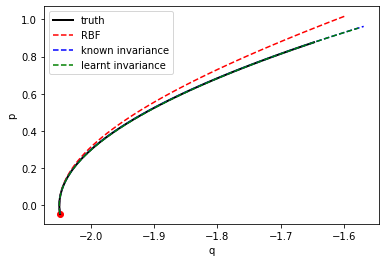

In [75]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/pendulum_predicted.pdf")

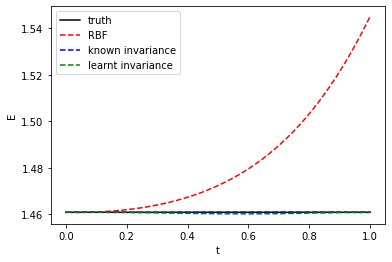

In [76]:
t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
plt.savefig("figures/pendulum_energy.pdf")

In [ ]:

import importlib, sys
importlib.reload(sys.modules["invariance_functions"])
from invariance_functions import evaluate_model_future

In [174]:

mean = ZeroMean(2)
invs =[5, 10, 20, 30, 40]
lmls = np.zeros(len(invs)+1)
future = np.zeros(len(invs)+1)
dofs = np.zeros(len(invs)+1)
energies = np.zeros(len(invs)+1)
dynamics = pendulum_dynamics
def energy(X):
    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])

test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))
print(np.degrees(test_starting_position))
print(np.degrees(test_starting_velocity))
test_starting = (test_starting_position, test_starting_velocity)
time_setting = (testing_time, time_step)

moi, *dump = get_GPR_model(get_MOI(), mean, data, 500)
evaluate_moi = evaluate_model_future(moi, test_starting, dynamics, time_setting, energy)

lmls[0]=(moi.log_marginal_likelihood().numpy())
dofs[0] = degree_of_freedom(moi.kernel, 3, 40,moi.likelihood.variance.numpy())
future[0]=(evaluate_moi[0])
energies[0]=abs((evaluate_moi[6][-1]-evaluate_moi[6][0])/evaluate_moi[6][0])
print(evaluate_moi[0])

invar_range = 3

jitter = 1e-3
for j, invar_density in enumerate(invs):
    known_kernel = get_invariance_kernel(PendulumInvariance, invar_range, invar_density, jitter) #switch
    m, *dump = get_GPR_model(known_kernel, mean,data, 500)
    lmls[j+1]=(m.log_marginal_likelihood().numpy())
    dofs[j+1] = degree_of_freedom(m.kernel, 3, 40, m.likelihood.variance.numpy())
    print(m.log_marginal_likelihood().numpy())


    evaluate_invariance = evaluate_model_future(m, test_starting, dynamics, time_setting, energy)
    print(format(evaluate_invariance[0],".4f"))
    future[j+1] = (evaluate_invariance[0])
    energies[j+1]=abs((evaluate_invariance[6][-1]-evaluate_invariance[6][0])/evaluate_invariance[6][0])



103.1036053975431
-9.391928535091353
0.004602347265623213
320.1813356544243
0.0019nds remainingg
325.92164558871207
0.0017nds remainingg
328.4772151617216
0.0017nds remainingg
329.72435614925894
0.0018nds remainingg
330.5563252919965
0.0017nds remainingg


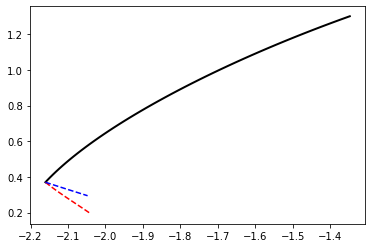

In [141]:

plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")

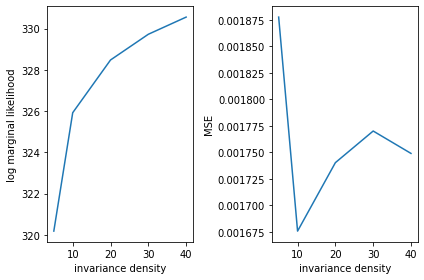

In [185]:

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(invs, lmls[1:])
#ax1.plot(invs, np.ones(len(invs))*lmls[0],'--', color="black")
ax1.set_ylabel("log marginal likelihood")
ax1.set_xlabel("invariance density")
#axs[0][0].set_xscale('log')
ax2.plot(invs, future[1:])
#ax2.plot(invs, np.ones(len(invs))*future[0],'--', color="black")
ax2.set_ylabel("MSE")
ax2.set_xlabel("invariance density")
#axs[0][1].set_xscale('log')
'''
axs[1][0].plot(invs, abs(energies[1:]))
axs[1][0].plot(invs, np.ones(len(invs))*energies[0],'--', color="black")
axs[1][0].set_xlabel("jitter")
axs[1][0].set_ylabel("Energy change(%)")
#axs[1][0].set_xscale('log')
axs[1][1].plot(invs, dofs[1:])
axs[1][1].plot(invs, np.ones(len(invs))*dofs[0],'--', color="black")
axs[1][1].set_ylabel("degree of freedom")
axs[1][1].set_xlabel("jitter")
#axs[1][1].set_xscale('log')
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
'''
plt.tight_layout()
plt.savefig("figures/vary_invariance.pdf")